# Выбор локации для скважины

___
**Описание проекта**  

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.  
___
**Цель**  

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.  
___
**Условия задачи:**

- Использовать модель линейной регрессии (остальные — недостаточно предсказуемые);
- Исследовать 500 точек при геологоразведке, выбрать 200 с наибольшими запасами для расчёта прибыли;
- Бюджет на разработку скважин в регионе — 10 млрд рублей;
- Стоимость одного барреля нефти 450 рублей. Объём указан в 1000 баррелей;
- Выбрать регионы, в которых вероятность убытков меньше 2.5%. Среди регионов, прошедших оценку рисков, выбрать один с наибольшей средней прибылью.  
___
**Описание данных:**  

*Признаки:*

`id` — уникальный идентификатор скважины;  
`f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);  
`product `— объём запасов в скважине (тыс. баррелей).

<h1>Содержание<span class="tocSkip"></span></h1><br>
<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1.&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li>
        <li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2.&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li>
        <li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3.&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li>
        <li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4.&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li>
        <li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5.&nbsp;&nbsp;</span>Общий вывод</a></span></li>
     
</div>

## 1. Загрузка и подготовка данных

### Считаем данные из csv-файлов в датафреймы и сохраним в переменные: `geo_data_0`, `geo_data_1`, `geo_data_2`.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

from datetime import datetime
from scipy import stats

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score

from sklearn.metrics import mean_squared_error

from sklearn.utils import shuffle

In [3]:
try:
    geo_data_0 = pd.read_csv('geo_data_0.csv')
    geo_data_1 = pd.read_csv('geo_data_1.csv')
    geo_data_2 = pd.read_csv('geo_data_2.csv')
except:
    print('File_not_found')

### Изучим общую информацию о полученных датафреймах

**Добавим настройки для удобства отображения данных**

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:,.4f}'.format

#Если необходимо вернуть дефолтные настройки, раскомментируй строку ниже
#pd.reset_option('all')

#### Регион 0

**Выведем первые 10 строчек датафрейма `geo_data_0` на экран.**

In [10]:
geo_data_0.head(10)

id      f0      f1      f2  product
0  txEyH  0.7057 -0.4978  1.2212 105.2801
1  2acmU  1.3347 -0.3402  4.3651  73.0378
2  409Wp  1.0227  0.1520  1.4199  85.2656
3  iJLyR -0.0322  0.1390  2.9786 168.6208
4  Xdl7t  1.9884  0.1554  4.7518 154.0366
5  wX4Hy  0.9696  0.4898 -0.7354  64.7415
6  tL6pL  0.6451  0.5307  1.7803  49.0553
7  BYPU6 -0.4006  0.8083 -5.6247  72.9433
8  j9Oui  0.6431 -0.5516  2.3721 113.3562
9  OLuZU  2.1734  0.5637  9.4419 127.9109

*Признаки:*

`id` — уникальный идентификатор скважины;  
`f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);  
`product `— объём запасов в скважине (тыс. баррелей).

**Посмотрим на размер данных (количество строк, колонок).**

In [11]:
print(f'\nКоличество строк: {geo_data_0.shape[0]}\nКоличество колонок: {geo_data_0.shape[1]}\n')


Количество строк: 100000
Количество колонок: 5



**Просмотрим статистическую сводку каждой колонки, чтобы узнать распределение данных в каждой колонки. Используем метод `describe()`.**

In [12]:
geo_data_0.describe(include = "all")

id           f0           f1           f2      product
count   100000 100,000.0000 100,000.0000 100,000.0000 100,000.0000
unique   99990          NaN          NaN          NaN          NaN
top      fiKDv          NaN          NaN          NaN          NaN
freq         2          NaN          NaN          NaN          NaN
mean       NaN       0.5004       0.2501       2.5026      92.5000
std        NaN       0.8718       0.5044       3.2482      44.2887
min        NaN      -1.4086      -0.8482     -12.0883       0.0000
25%        NaN      -0.0726      -0.2009       0.2877      56.4975
50%        NaN       0.5024       0.2503       2.5160      91.8500
75%        NaN       1.0736       0.7006       4.7151     128.5641
max        NaN       2.3623       1.3438      16.0038     185.3643

**Выведем основную информацию о датафрейме с помощью метода `info()`.**

In [13]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**Выведем количество пропущенных значений для каждой колонки.**

In [14]:
pd.DataFrame(geo_data_0.isna().sum()).style.background_gradient('coolwarm')

**Проверим дубликаты.**

In [15]:
geo_data_0.duplicated().sum()

0

**Посмотрим на распределения числовых признаков `f0`, `f1`, `f2`, `product`.**

In [18]:
def plots_numerics(data, x, xlabel=None, ylabel=None, title=None, suptitle=None, nrows=1, ncols=1, figsize=(3 , 3)):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    for index in range(len(x)):

        plot = sns.histplot(data[x[index]],
                            color='blue',
                            stat='density',
                            ax=axes[0, index])
        sns.kdeplot(data[x[index]],
                    color='yellow',
                    alpha=0.5,
                    linewidth=3.5,
                    ax=axes[0, index])
        plot.axvline(data[x[index]].mean(), label='mean', c='k', ls='-', lw=2.5)
        plot.axvline(data[x[index]].median(), label='median', c='orange', ls='--', lw=2.5)
        axes[0, index].set(xlabel=xlabel)
        axes[0, index].set(ylabel=ylabel)

        sns.boxplot(data=data, x=x[index], color='yellow', ax=axes[1, index])
        sns.stripplot(data=data, x=x[index], color='blue', jitter=0.4, size=0.9, alpha=0.5, ax=axes[1, index])
        axes[1, index].set(xlabel=xlabel)
        axes[1, index].set(ylabel=ylabel)

        sns.violinplot(data=data, x=x[index],color='yellow', ax=axes[2, index])
        axes[2, index].set(xlabel=xlabel)
        axes[2, index].set(ylabel=ylabel)

        axes[0, index].set_title(title[x[index]], fontsize=18, pad=15)

    fig.suptitle(suptitle, fontsize=22)
    plt.show()

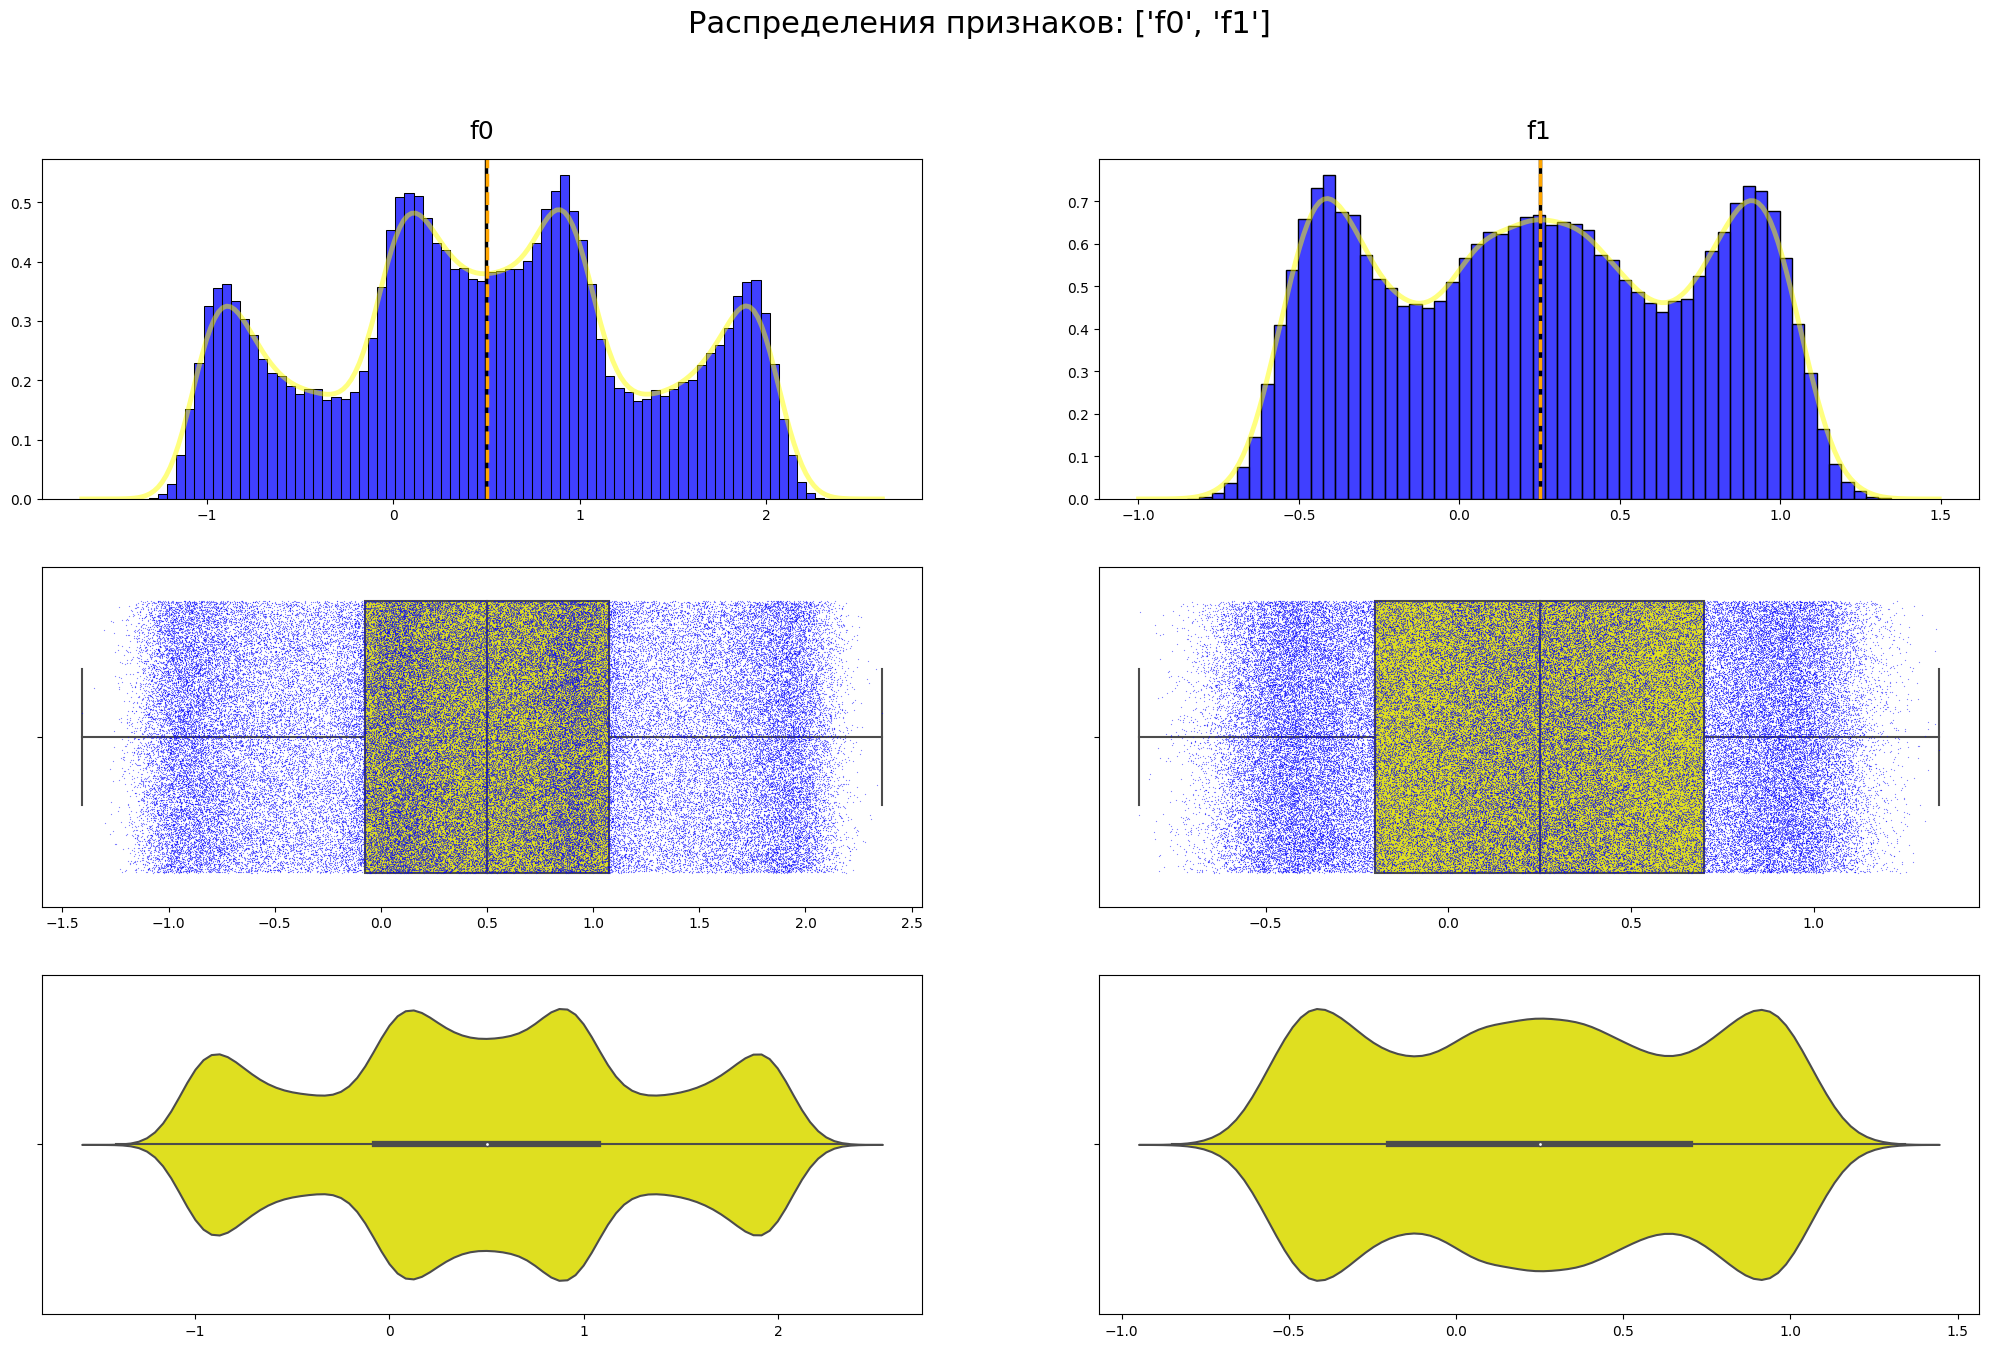

In [19]:
numerical = ['f0', 'f1']

plots_numerics(data=geo_data_0,
               x=numerical,
               xlabel=None,
               ylabel=None,
               title={'f0': 'f0',
                      'f1': 'f1'},
               suptitle=(f'Распределения признаков: {numerical}'),
               nrows=3,
               ncols=2,
               figsize=(25, 15))

**Значения признаков `f0` и `f1` распределены нормально относительно медианы и среднего значения. Медиана и средняя не смещена относительно друг друга. На графиках `boxplot` нет выбросов данных.**  
**Видим на графиках `kdeplot` и `violinplot` противоположное несовпадение пиков значений относительно друг друга для признаков `f0` и `f1`, что косвенно говорит об отрицательной корреляции.**  

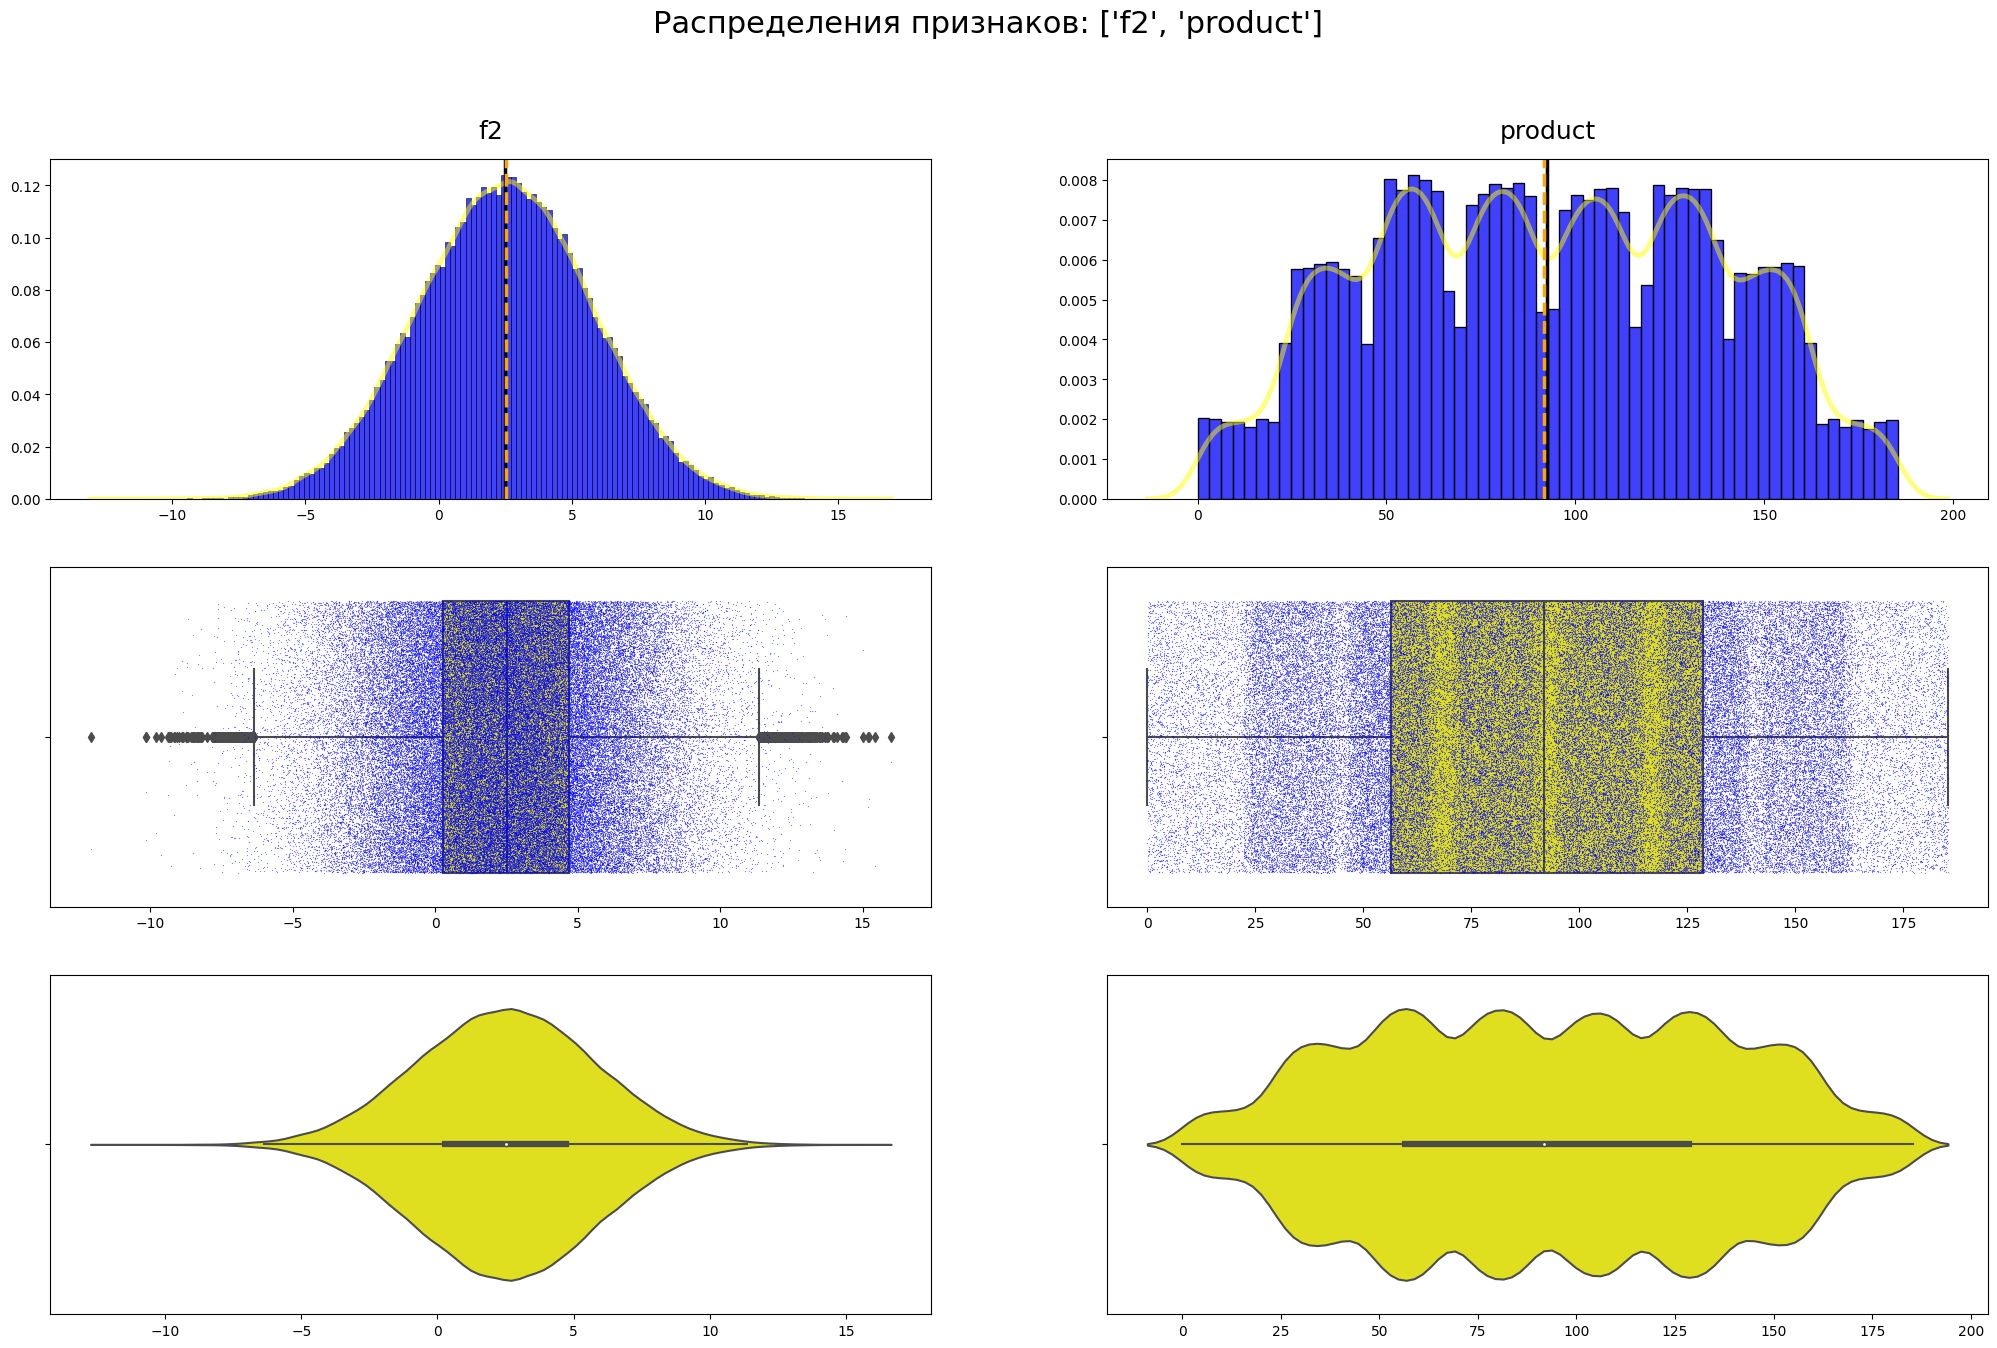

In [20]:
numerical = ['f2', 'product']

plots_numerics(data=geo_data_0,
               x=numerical,
               xlabel=None,
               ylabel=None,
               title={'f2': 'f2',
                      'product': 'product'},
               suptitle=(f'Распределения признаков: {numerical}'),
               nrows=3,
               ncols=2,
               figsize=(25, 15))

**Значения признаков `f2` и `product` распределены нормально относительно медианы и среднего значения. Медиана и средняя не смещена относительно друг друга.**  
**На графике `boxplot` для признака `f2` заметно небольшое количество выбросов данных.**  
**На графике `kdeplot` и `violinplot` для признака `product` выражены `6` групп пиковых значений.**

**Матрица корреляций:**

<ipython-input-21-53361a3216bb>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = geo_data_0.corr()


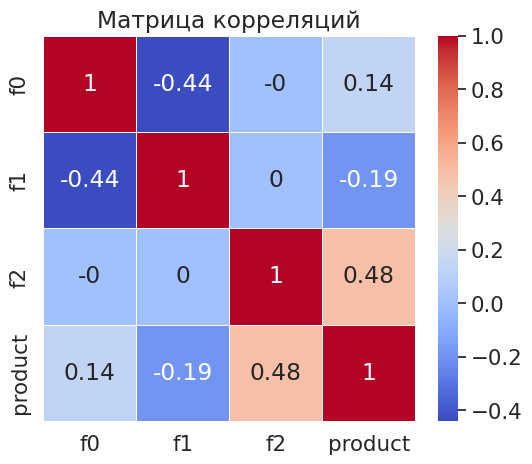

In [21]:
plt.figure(figsize=(6, 5))

sns.set(font_scale=1.4)
sns.set_style('whitegrid')

corr_matrix = geo_data_0.corr()
corr_matrix = np.round(corr_matrix, 2)

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Матрица корреляций')
plt.show()

**Видим `среднюю отрицательную корреляцию` признаков `f0` и `f1`, что совпадает с графиками полученными ранее.**  
**Видим `среднюю положительную корреляцию` признаков `product` и `f2`, что совпадает с графиками полученными ранее.**  
**В остальных признаках выраженных `линейных корреляций` `не выявлено`.**

**Промежуточные выводы:**

>1. Значения признаков `f0` и `f1` распределены нормально относительно медианы и среднего значения. Медиана и средняя не смещена относительно друг друга. На графиках `boxplot` нет выбросов данных.
>2. Видим на графиках `kdeplot` и `violinplot` противоположное несовпадение пиков значений относительно друг друга для признаков `f0` и `f1`, что косвенно говорит об отрицательной корреляции.
>3. Значения признаков `f2` и `product` распределены нормально относительно медианы и среднего значения. Медиана и средняя не смещена относительно друг друга.
>4. На графике `boxplot` для признака `f2` заметно небольшое количество выбросов данных.
>5. На графике `kdeplot` и `violinplot` для признака `product` выражены `6` групп пиковых значений.
>6. Видим `среднюю отрицательную корреляцию` признаков `f0` и `f1`, что совпадает с графиками полученными ранее.  
>7. Видим `среднюю положительную корреляцию` признаков `product` и `f2`, что совпадает с графиками полученными ранее.
>8. В остальных признаках выраженных `линейных корреляций` `не выявлено`.

**Посчитаем процент выбросов числовых признаков `f0`, `f1`, `f2`, `product` методом "z оценки".**

In [22]:
numerical = ['f0', 'f1', 'f2', 'product']
for i in numerical:
    z = np.abs(stats.zscore(geo_data_0[i]))
    outliners = geo_data_0[i].iloc[np.where(z > 3)].count() / geo_data_0[i].shape[0]
    print(f'\nПроцент выбросов в признаке {i} равен: {outliners:.2%}')


Процент выбросов в признаке f0 равен: 0.00%

Процент выбросов в признаке f1 равен: 0.00%

Процент выбросов в признаке f2 равен: 0.18%

Процент выбросов в признаке product равен: 0.00%


**Количество выбросов найденных методом "z оценки" относительно небольшое.**

#### Регион 1

**Выведем первые 10 строчек датафрейма `geo_data_1` на экран.**

In [23]:
geo_data_1.head(10)

id       f0       f1      f2  product
0  kBEdx -15.0013  -8.2760 -0.0059   3.1791
1  62mP7  14.2721  -3.4751  0.9992  26.9533
2  vyE1P   6.2632  -5.9484  5.0012 134.7663
3  KcrkZ -13.0812 -11.5061  4.9994 137.9454
4  AHL4O  12.7022  -8.1474  5.0044 134.7663
5  HHckp  -3.3276  -2.2053  3.0036  84.0389
6  h5Ujo -11.1427 -10.1334  4.0024 110.9921
7  muH9x   4.2347  -0.0014  2.0046  53.9065
8  YiRkx  13.3551  -0.3321  4.9986 134.7663
9  jG6Gi   1.0692 -11.0257  4.9978 137.9454

*Признаки:*

`id` — уникальный идентификатор скважины;  
`f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);  
`product `— объём запасов в скважине (тыс. баррелей).

**Посмотрим на размер данных (количество строк, колонок).**

In [24]:
print(f'\nКоличество строк: {geo_data_1.shape[0]}\nКоличество колонок: {geo_data_1.shape[1]}\n')


Количество строк: 100000
Количество колонок: 5



**Просмотрим статистическую сводку каждой колонки, чтобы узнать распределение данных в каждой колонки. Используем метод `describe()`.**

In [25]:
geo_data_1.describe(include = "all")

id           f0           f1           f2      product
count   100000 100,000.0000 100,000.0000 100,000.0000 100,000.0000
unique   99996          NaN          NaN          NaN          NaN
top      wt4Uk          NaN          NaN          NaN          NaN
freq         2          NaN          NaN          NaN          NaN
mean       NaN       1.1413      -4.7966       2.4945      68.8250
std        NaN       8.9659       5.1199       1.7036      45.9444
min        NaN     -31.6096     -26.3586      -0.0181       0.0000
25%        NaN      -6.2986      -8.2680       1.0000      26.9533
50%        NaN       1.1531      -4.8132       2.0115      57.0856
75%        NaN       8.6210      -1.3328       3.9999     107.8130
max        NaN      29.4218      18.7341       5.0197     137.9454

**Выведем основную информацию о датафрейме с помощью метода `info()`.**

In [26]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**Выведем количество пропущенных значений для каждой колонки.**

In [27]:
pd.DataFrame(geo_data_1.isna().sum()).style.background_gradient('coolwarm')

**Проверим дубликаты.**

In [28]:
geo_data_1.duplicated().sum()

0

**Посмотрим на распределения числовых признаков `f0`, `f1`, `f2`, `product`.**

In [29]:
def plots_numerics(data, x, xlabel=None, ylabel=None, title=None, suptitle=None, nrows=1, ncols=1, figsize=(3 , 3)):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    for index in range(len(x)):

        plot = sns.histplot(data[x[index]],
                            color='blue',
                            stat='density',
                            ax=axes[0, index])
        sns.kdeplot(data[x[index]],
                    color='yellow',
                    alpha=0.5,
                    linewidth=3.5,
                    ax=axes[0, index])
        plot.axvline(data[x[index]].mean(), label='mean', c='k', ls='-', lw=2.5)
        plot.axvline(data[x[index]].median(), label='median', c='orange', ls='--', lw=2.5)
        axes[0, index].set(xlabel=xlabel)
        axes[0, index].set(ylabel=ylabel)

        sns.boxplot(data=data, x=x[index], color='yellow', ax=axes[1, index])
        sns.stripplot(data=data, x=x[index], color='blue', jitter=0.4, size=0.9, alpha=0.5, ax=axes[1, index])
        axes[1, index].set(xlabel=xlabel)
        axes[1, index].set(ylabel=ylabel)

        sns.violinplot(data=data, x=x[index],color='yellow', ax=axes[2, index])
        axes[2, index].set(xlabel=xlabel)
        axes[2, index].set(ylabel=ylabel)

        axes[0, index].set_title(title[x[index]], fontsize=18, pad=15)

    fig.suptitle(suptitle, fontsize=22)
    plt.show()

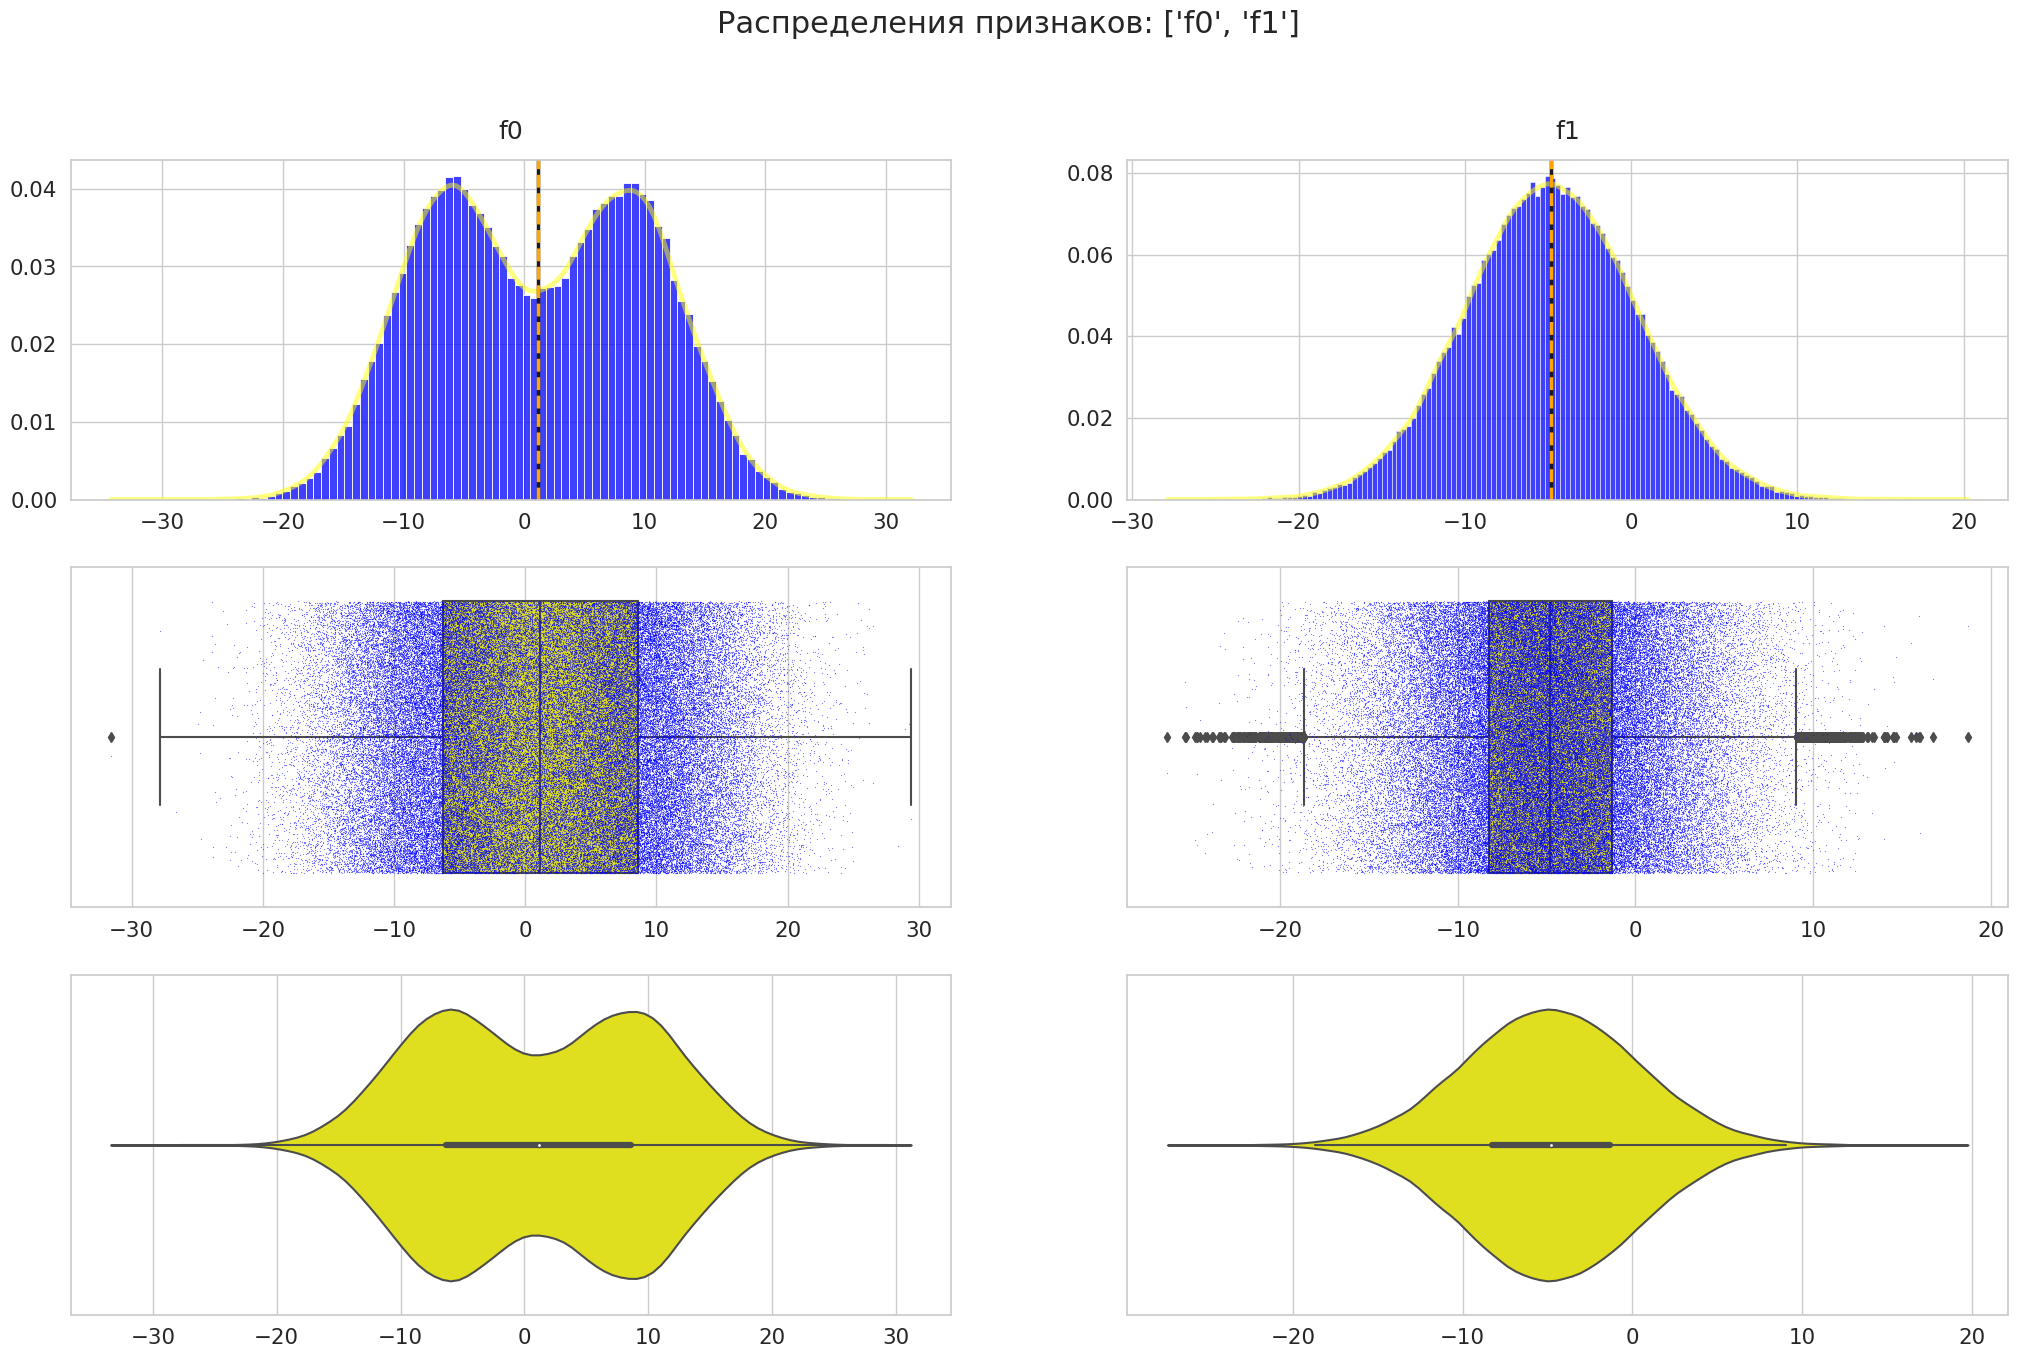

In [30]:
numerical = ['f0', 'f1']

plots_numerics(data=geo_data_1,
               x=numerical,
               xlabel=None,
               ylabel=None,
               title={'f0': 'f0',
                      'f1': 'f1'},
               suptitle=(f'Распределения признаков: {numerical}'),
               nrows=3,
               ncols=2,
               figsize=(25, 15))

**Значения признаков `f0` и `f1` распределены нормально относительно медианы и среднего значения. Медиана и средняя не смещена относительно друг друга. На графиках `boxplot` нет выбросов данных.**  
**Видим на графиках `kdeplot` и `violinplot` противоположное несовпадение пиков значений относительно друг друга для признаков `f0` и `f1`.**  

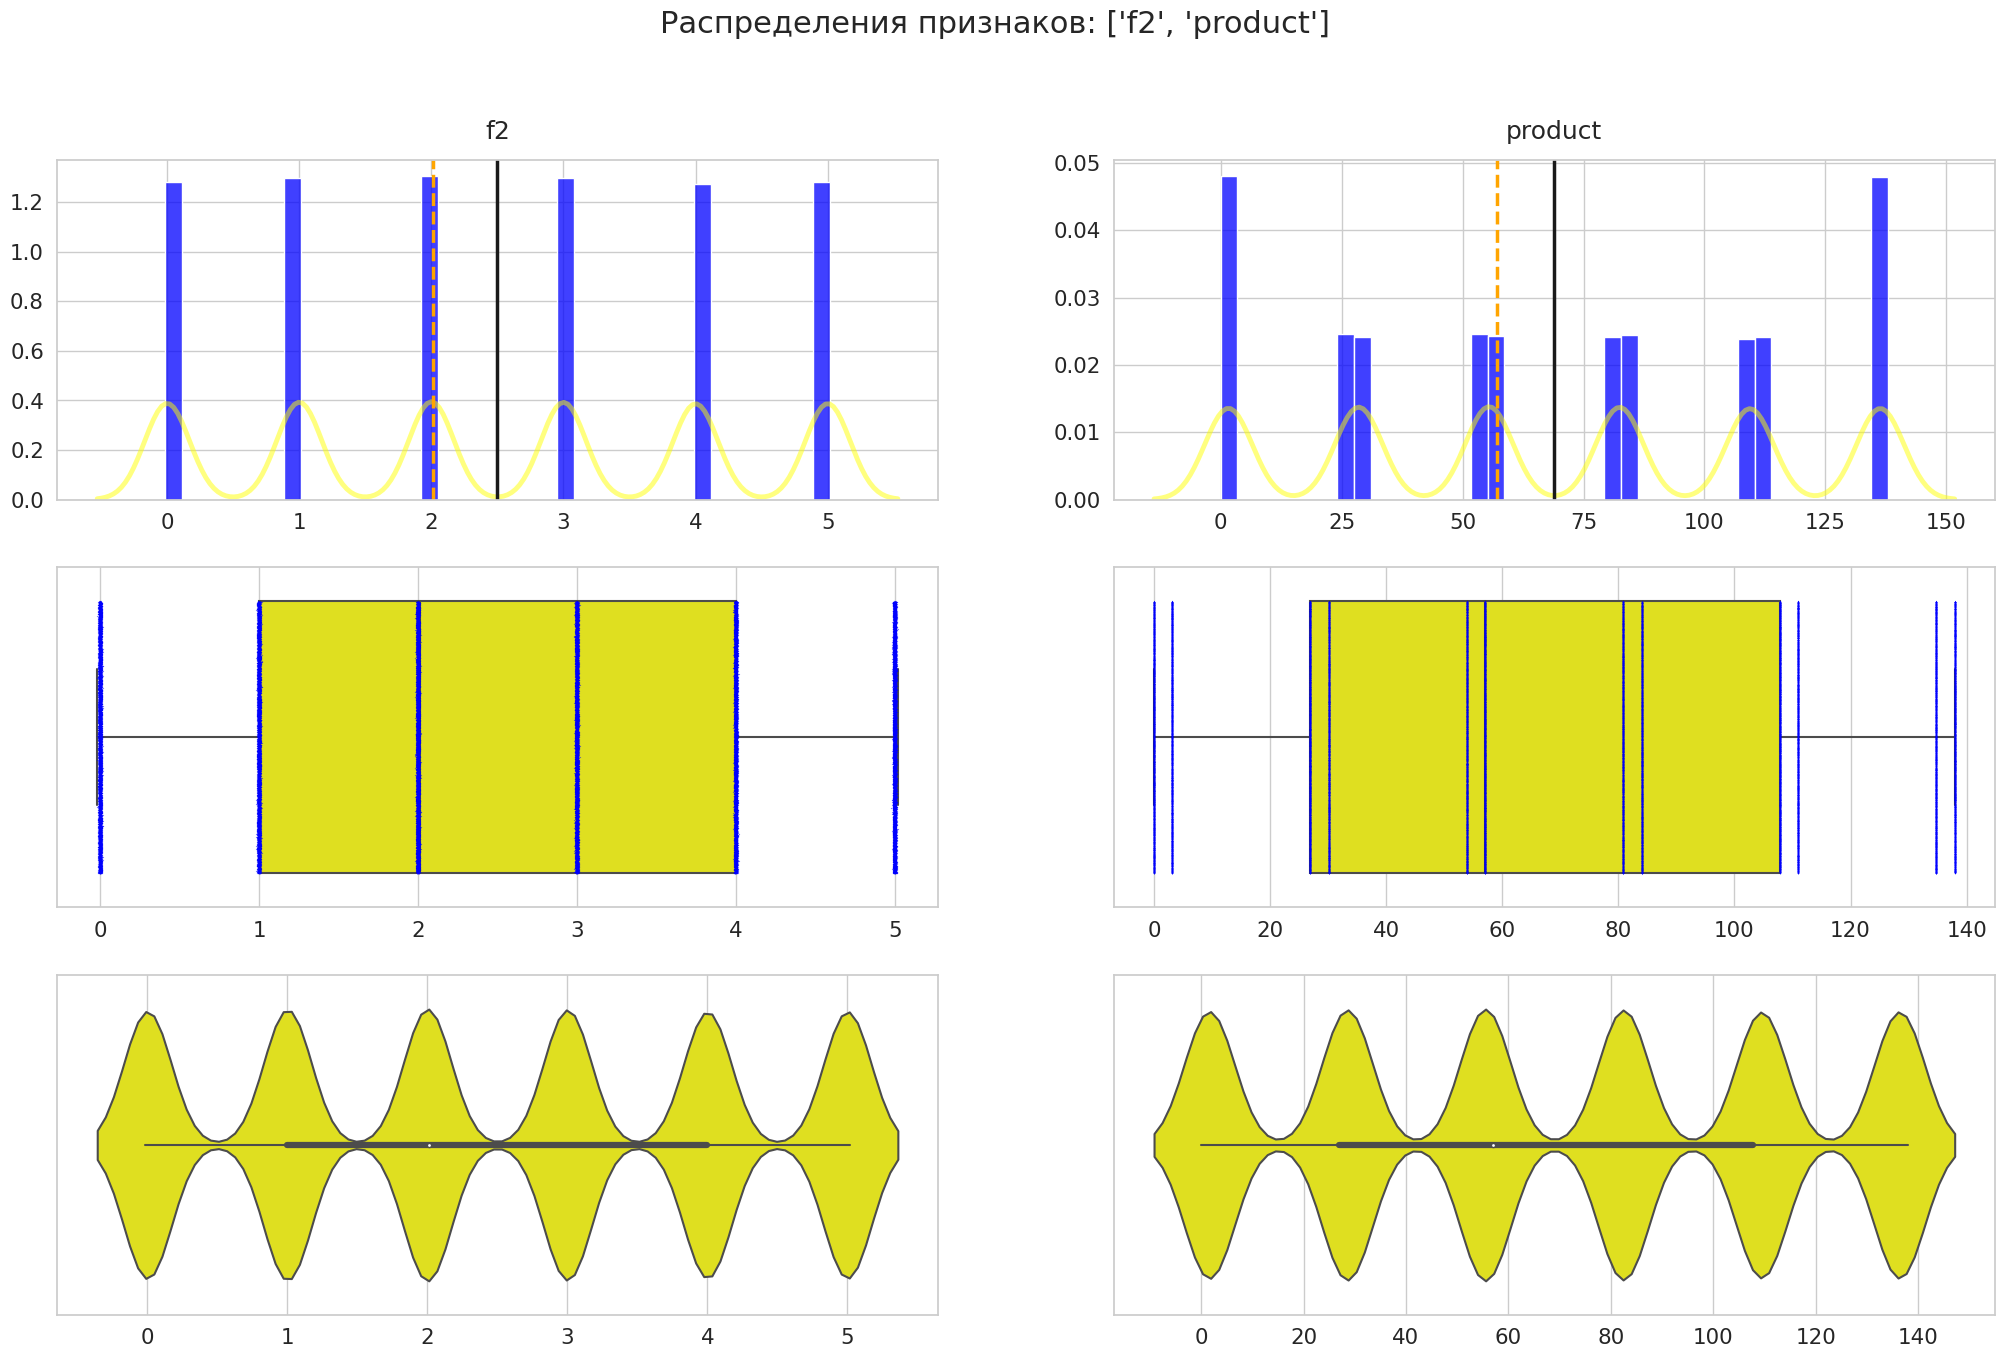

In [31]:
numerical = ['f2', 'product']

plots_numerics(data=geo_data_1,
               x=numerical,
               xlabel=None,
               ylabel=None,
               title={'f2': 'f2',
                      'product': 'product'},
               suptitle=(f'Распределения признаков: {numerical}'),
               nrows=3,
               ncols=2,
               figsize=(25, 15))

In [32]:
geo_data_1['product'].value_counts()

53.9065     8472
26.9533     8468
84.0389     8431
57.0856     8390
3.1791      8337
80.8598     8320
30.1324     8306
134.7663    8304
110.9921    8303
0.0000      8235
137.9454    8233
107.8130    8201
Name: product, dtype: int64

**Значения признаков `f2` и `product` распределены нормально относительно медианы и среднего значения.**  
**Среднее значение признаков `f2` и `product` немного смещена влево относительно медианы. Что говорит нам о небольшой несбалансированности данных числовых признаков.**  
**Видим на графиках `kdeplot` и `violinplot` практически абсолютное повторение распределения `6ти пиковых` значений призкаков `f2` и `product`, что предварительно говорит о сильной корреляции значений.**  
**В признаке `product` всего `12` уникальных значений.**

**Матрица корреляций:**

<ipython-input-33-f2d3b42bbb58>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = geo_data_1.corr()


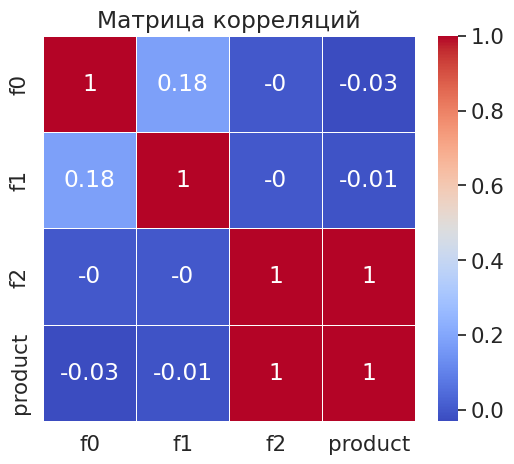

In [33]:
plt.figure(figsize=(6, 5))

sns.set(font_scale=1.4)
sns.set_style('whitegrid')

corr_matrix = geo_data_1.corr()
corr_matrix = np.round(corr_matrix, 2)

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Матрица корреляций')
plt.show()

**Видим `очень высокую положительную корреляцию` признаков `product` и `f2`, что совпадает с графиками полученными ранее.**  
**В остальных признаках выраженных `линейных корреляций` `не выявлено`.**

**Промежуточные выводы:**

>1. Значения признаков `f0` и `f1` распределены нормально относительно медианы и среднего значения. Медиана и средняя не смещена относительно друг друга. На графиках `boxplot` нет выбросов данных.**  
>2. Видим на графиках `kdeplot` и `violinplot` противоположное несовпадение пиков значений относительно друг друга для признаков `f0` и `f1`.
>3. Значения признаков `f2` и `product` распределены нормально относительно медианы и среднего значения.
>4. Среднее значение признаков `f2` и `product` немного смещена влево относительно медианы. Что говорит нам о небольшой несбалансированности данных числовых признаков.
>5. Видим на графиках `kdeplot` и `violinplot` явное повторение распределения `6ти пиковых` значений призкаков `f2` и `product`, что предварительно говорит о сильной корреляции значений.
>6. В признаке `product` всего `12` уникальных значений.
>7. Видим `очень высокую положительную корреляцию` признаков `product` и `f2`, что совпадает с графиками полученными ранее.
>8. В остальных признаках выраженных `линейных корреляций` `не выявлено`.

**Посчитаем процент выбросов числовых признаков `f0`, `f1`, `f2`, `product` методом "z оценки".**

In [34]:
numerical = ['f0', 'f1', 'f2', 'product']
for i in numerical:
    z = np.abs(stats.zscore(geo_data_1[i]))
    outliners = geo_data_1[i].iloc[np.where(z > 3)].count() / geo_data_1[i].shape[0]
    print(f'\nПроцент выбросов в признаке {i} равен: {outliners:.2%}')


Процент выбросов в признаке f0 равен: 0.01%

Процент выбросов в признаке f1 равен: 0.26%

Процент выбросов в признаке f2 равен: 0.00%

Процент выбросов в признаке product равен: 0.00%


**Количество выбросов найденных методом "z оценки" относительно небольшое.**

#### Регион 2

**Выведем первые 10 строчек датафрейма `geo_data_2` на экран.**

In [35]:
geo_data_2.head(10)

id      f0      f1      f2  product
0  fwXo0 -1.1470  0.9633 -0.8290  27.7587
1  WJtFt  0.2628  0.2698 -2.5302  56.0697
2  ovLUW  0.1946  0.2890 -5.5864  62.8719
3  q6cA6  2.2361 -0.5538  0.9300 114.5728
4  WPMUX -0.5160  1.7163  5.8990 149.6007
5  LzZXx -0.7581  0.7107  2.5859  90.2225
6  WBHRv -0.5749  0.3177  1.7737  45.6415
7  XO8fn -1.9066 -2.4584 -0.1771  72.4806
8  ybmQ5  1.7763 -0.2794  3.0042 106.6168
9  OilcN -1.2145 -0.4393  5.9225  52.9545

*Признаки:*

`id` — уникальный идентификатор скважины;  
`f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);  
`product `— объём запасов в скважине (тыс. баррелей).

**Посмотрим на размер данных (количество строк, колонок).**

In [36]:
print(f'\nКоличество строк: {geo_data_2.shape[0]}\nКоличество колонок: {geo_data_2.shape[1]}\n')


Количество строк: 100000
Количество колонок: 5



**Просмотрим статистическую сводку каждой колонки, чтобы узнать распределение данных в каждой колонки. Используем метод `describe()`.**

In [37]:
geo_data_2.describe(include = "all")

id           f0           f1           f2      product
count   100000 100,000.0000 100,000.0000 100,000.0000 100,000.0000
unique   99996          NaN          NaN          NaN          NaN
top      VF7Jo          NaN          NaN          NaN          NaN
freq         2          NaN          NaN          NaN          NaN
mean       NaN       0.0020      -0.0021       2.4951      95.0000
std        NaN       1.7320       1.7304       3.4734      44.7499
min        NaN      -8.7600      -7.0840     -11.9703       0.0000
25%        NaN      -1.1623      -1.1748       0.1304      59.4504
50%        NaN       0.0094      -0.0095       2.4842      94.9256
75%        NaN       1.1585       1.1637       4.8588     130.5950
max        NaN       7.2383       7.8448      16.7394     190.0298

**Выведем основную информацию о датафрейме с помощью метода `info()`.**

In [38]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**Выведем количество пропущенных значений для каждой колонки.**

In [39]:
pd.DataFrame(geo_data_2.isna().sum()).style.background_gradient('coolwarm')

**Проверим дубликаты.**

In [40]:
geo_data_2.duplicated().sum()

0

**Посмотрим на распределения числовых признаков `f0`, `f1`, `f2`, `product`.**

In [42]:
def plots_numerics(data, x, xlabel=None, ylabel=None, title=None, suptitle=None, nrows=1, ncols=1, figsize=(3 , 3)):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    for index in range(len(x)):

        plot = sns.histplot(data[x[index]],
                            color='blue',
                            stat='density',
                            ax=axes[0, index])
        sns.kdeplot(data[x[index]],
                    color='yellow',
                    alpha=0.5,
                    linewidth=3.5,
                    ax=axes[0, index])
        plot.axvline(data[x[index]].mean(), label='mean', c='k', ls='-', lw=2.5)
        plot.axvline(data[x[index]].median(), label='median', c='orange', ls='--', lw=2.5)
        axes[0, index].set(xlabel=xlabel)
        axes[0, index].set(ylabel=ylabel)

        sns.boxplot(data=data, x=x[index], color='yellow', ax=axes[1, index])
        sns.stripplot(data=data, x=x[index], color='blue', jitter=0.4, size=0.9, alpha=0.5, ax=axes[1, index])
        axes[1, index].set(xlabel=xlabel)
        axes[1, index].set(ylabel=ylabel)

        sns.violinplot(data=data, x=x[index],color='yellow', ax=axes[2, index])
        axes[2, index].set(xlabel=xlabel)
        axes[2, index].set(ylabel=ylabel)

        axes[0, index].set_title(title[x[index]], fontsize=18, pad=15)

    fig.suptitle(suptitle, fontsize=22)
    plt.show()

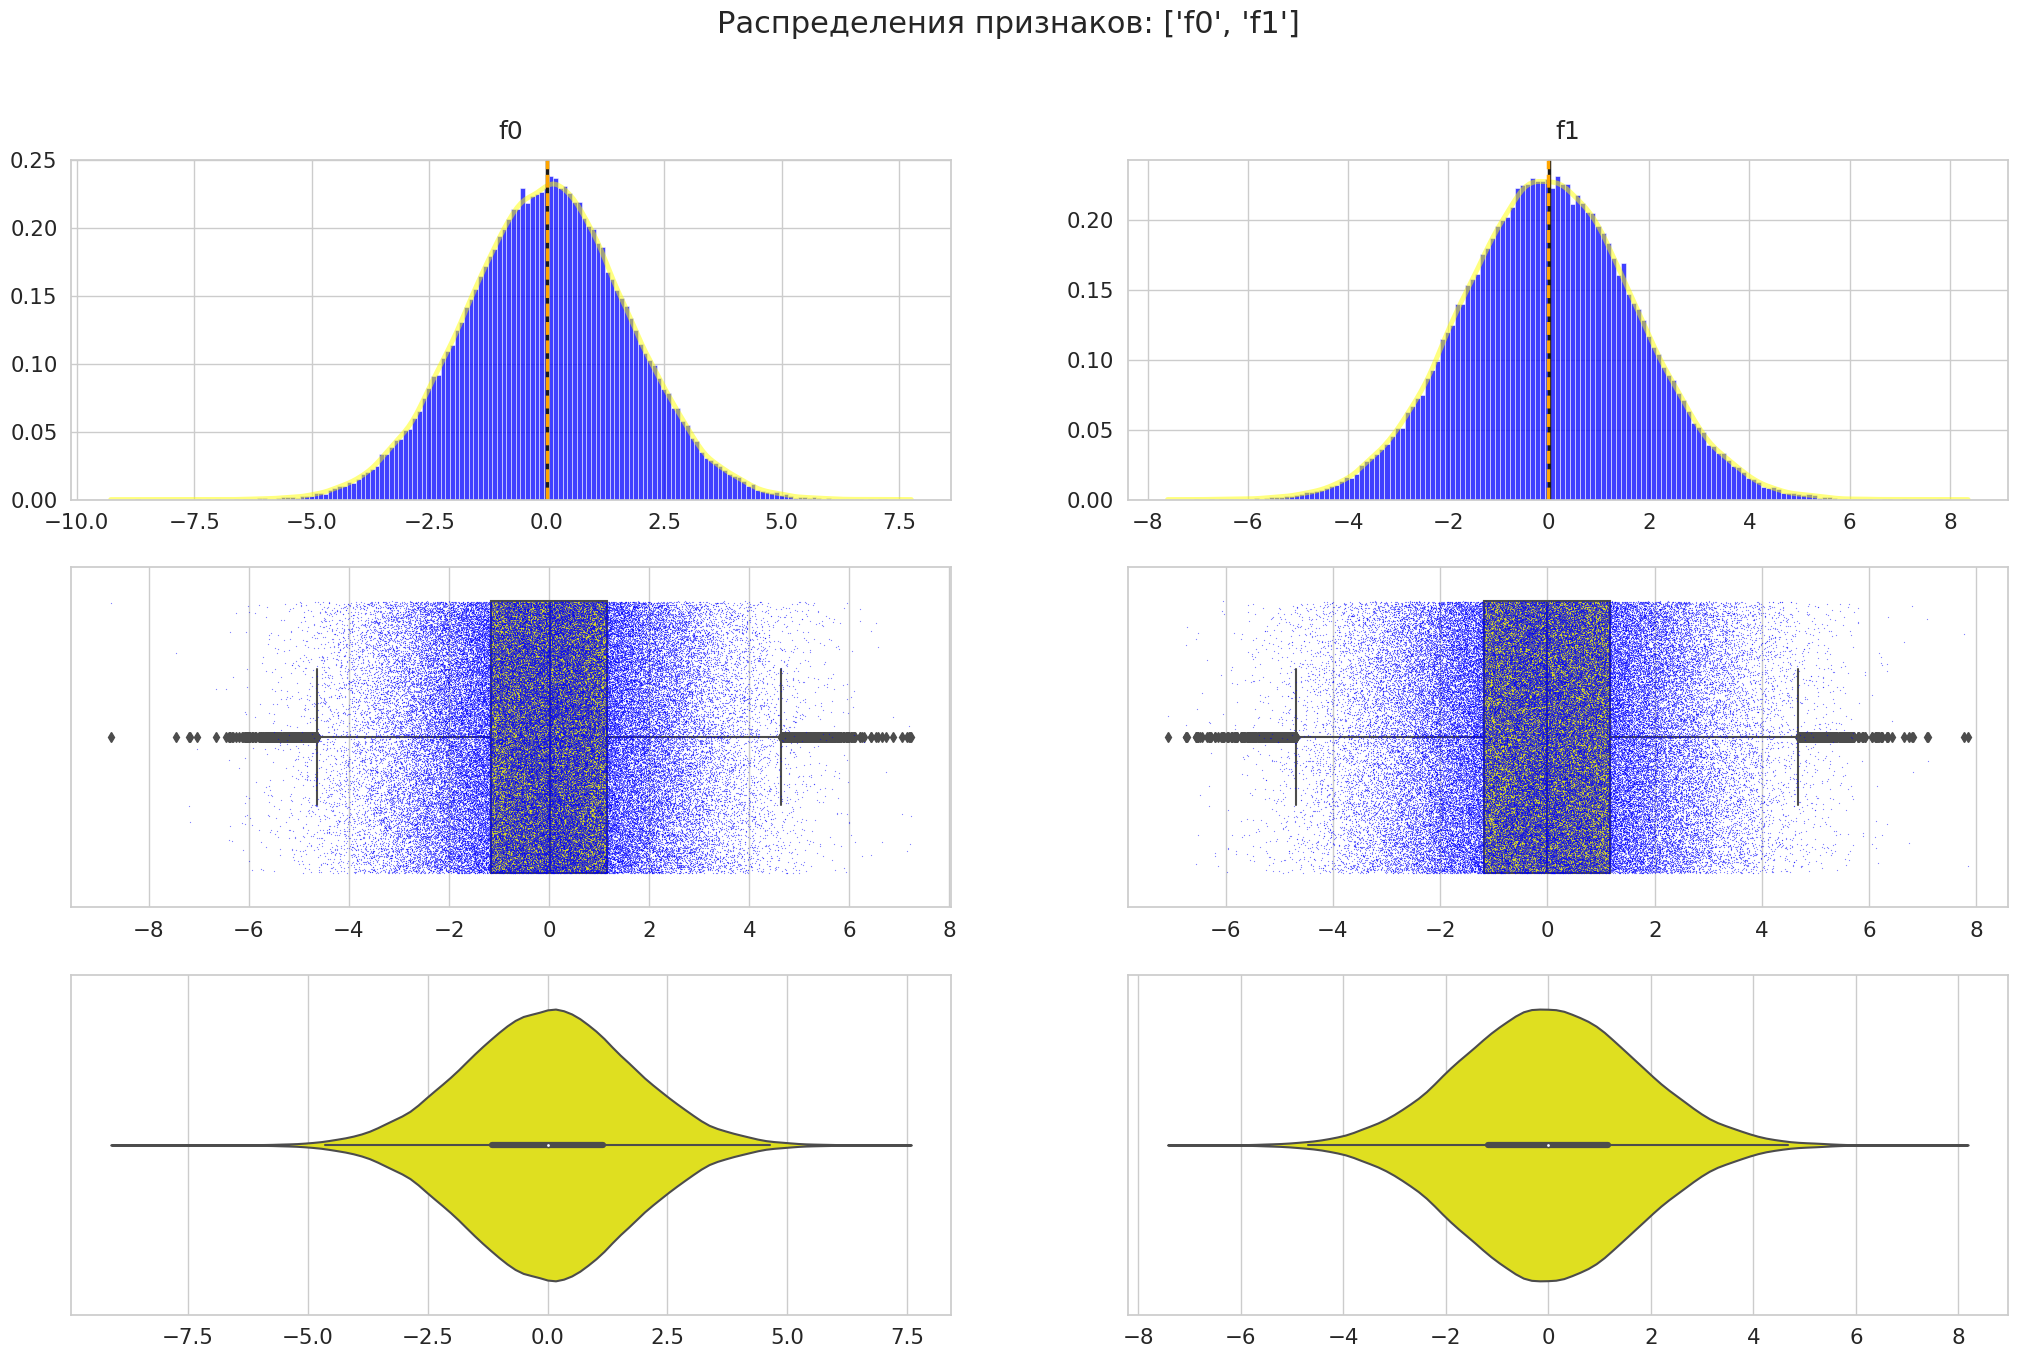

In [43]:
numerical = ['f0', 'f1']

plots_numerics(data=geo_data_2,
               x=numerical,
               xlabel=None,
               ylabel=None,
               title={'f0': 'f0',
                      'f1': 'f1'},
               suptitle=(f'Распределения признаков: {numerical}'),
               nrows=3,
               ncols=2,
               figsize=(25, 15))

**Значения признаков `f0` и `f1` распределены нормально относительно медианы и среднего значения. Медиана и средняя не смещена относительно друг друга.**  
**На графиках `boxplot` для признаков `f0` и `f1` видим небольшое количество выбросов данных.**

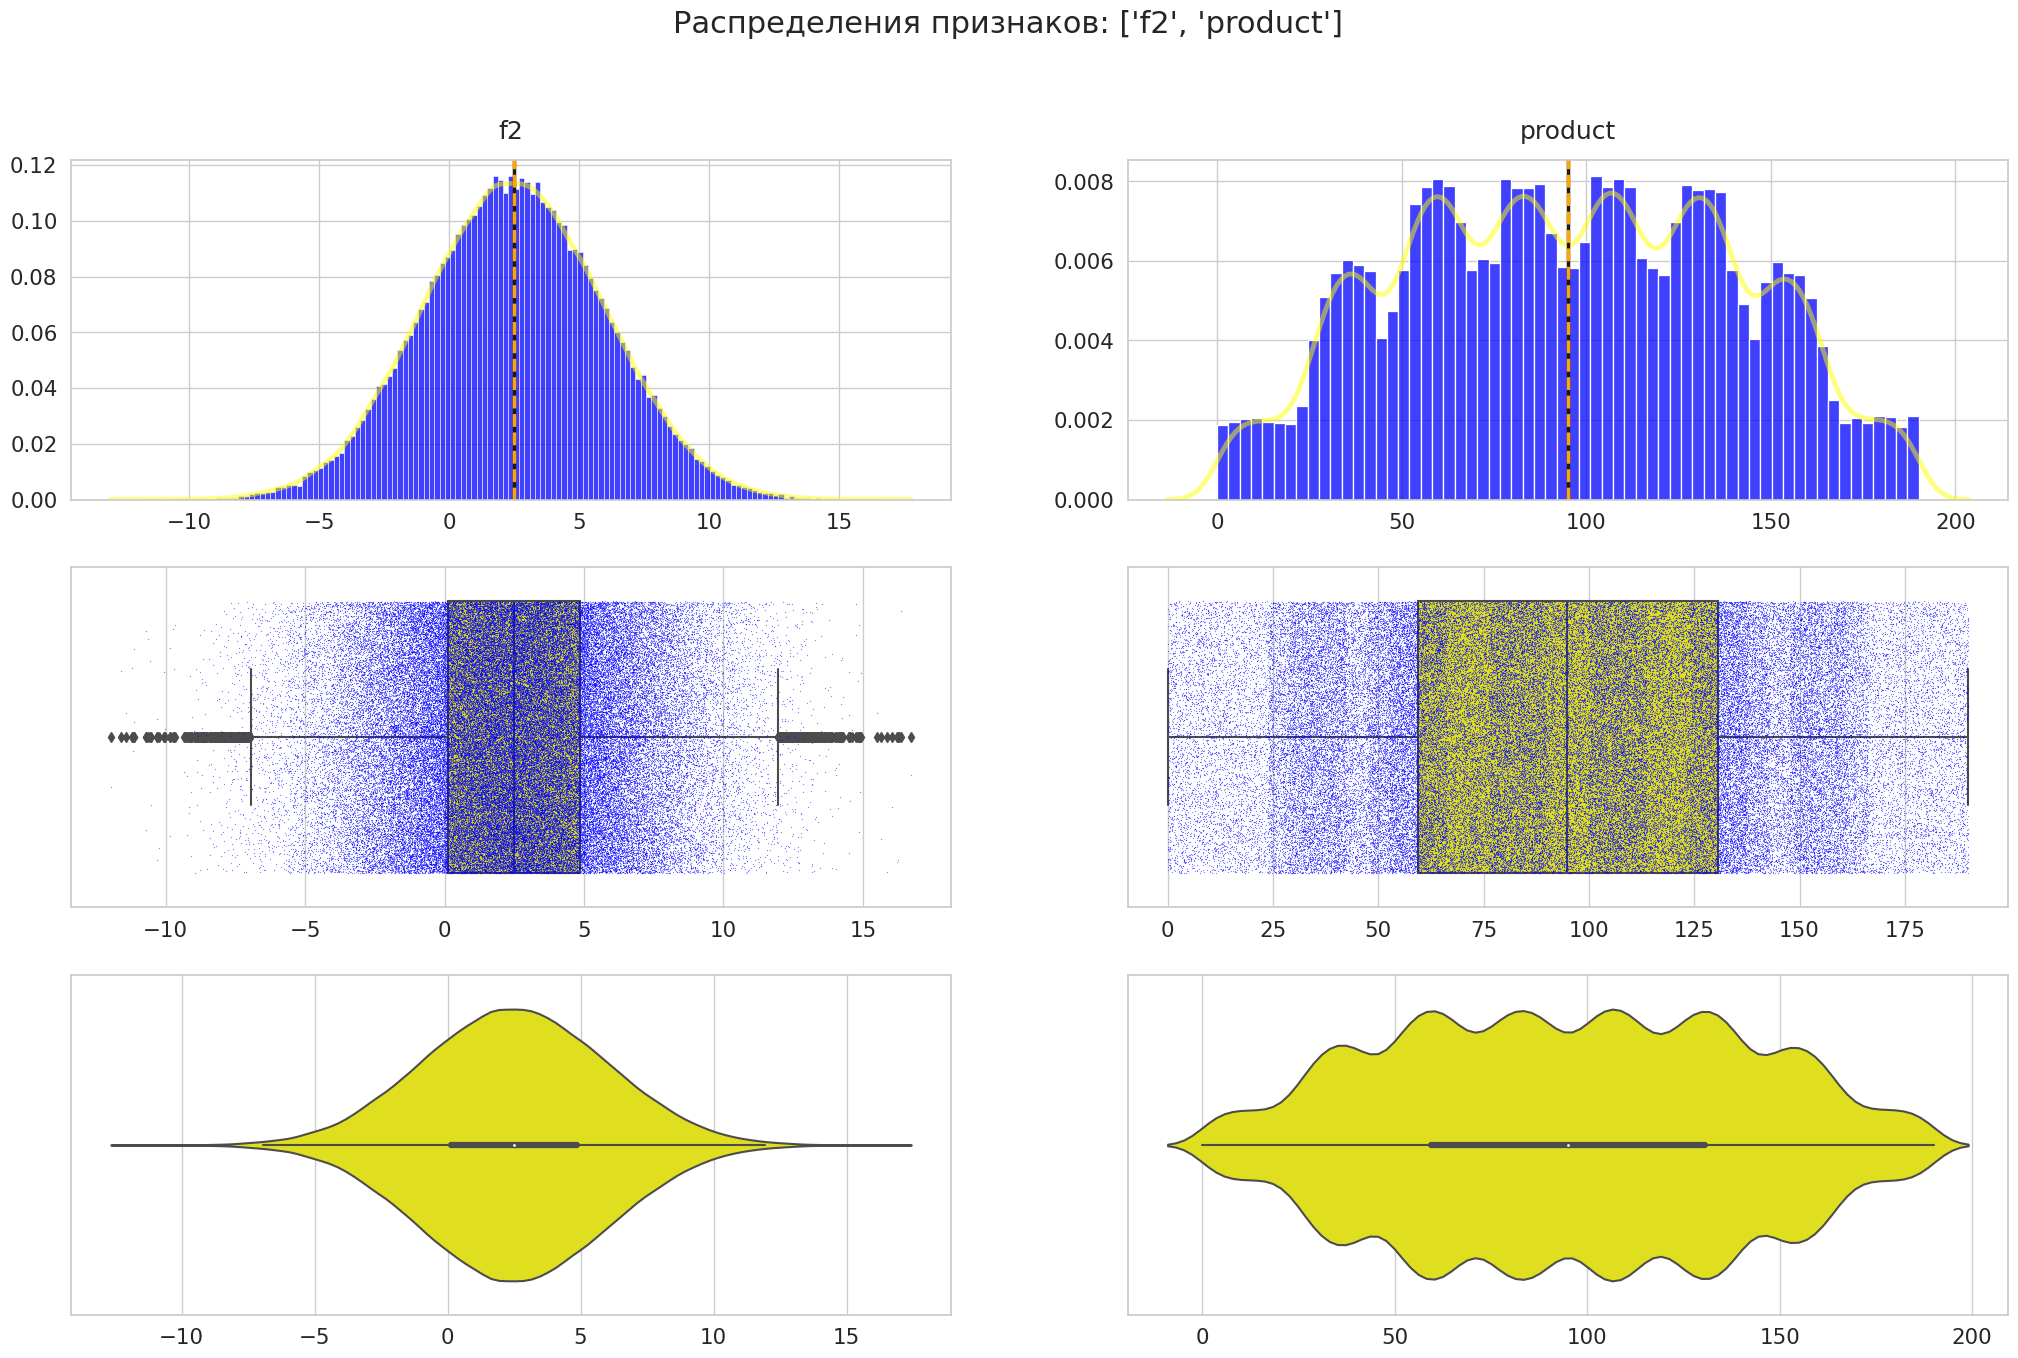

In [44]:
numerical = ['f2', 'product']

plots_numerics(data=geo_data_2,
               x=numerical,
               xlabel=None,
               ylabel=None,
               title={'f2': 'f2',
                      'product': 'product'},
               suptitle=(f'Распределения признаков: {numerical}'),
               nrows=3,
               ncols=2,
               figsize=(25, 15))

**Значения признаков `f2` и `product` распределены нормально относительно медианы и среднего значения. Медиана и средняя не смещена относительно друг друга.**  
**На графике `boxplot` для признака `f2` заметно небольшое количество выбросов данных.**  
**На графике `kdeplot` и `violinplot` для признака `product` выражены `6` групп пиковых значений.**

**Матрица корреляций:**

<ipython-input-45-8a108e2f6d34>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = geo_data_2.corr()


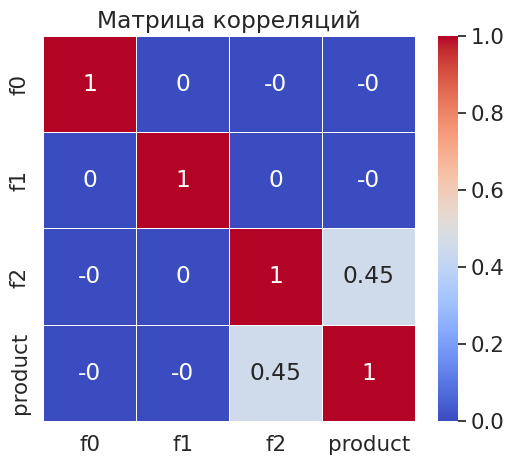

In [45]:
plt.figure(figsize=(6, 5))

sns.set(font_scale=1.4)
sns.set_style('whitegrid')

corr_matrix = geo_data_2.corr()
corr_matrix = np.round(corr_matrix, 2)

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Матрица корреляций')
plt.show()

**Видим `среднюю положительную корреляцию` признаков `product` и `f2`, что совпадает с графиками полученными ранее.**  
**В остальных признаках выраженных `линейных корреляций` `не выявлено`.**

**Промежуточные выводы:**

>1. Значения признаков `f0` и `f1` распределены нормально относительно медианы и среднего значения. Медиана и средняя не смещена относительно друг друга.
>2. На графиках `boxplot` для признаков `f0` и `f1` видим небольшое количество выбросов данных.
>3. Значения признаков `f2` и `product` распределены нормально относительно медианы и среднего значения. Медиана и средняя не смещена относительно друг друга.
>4. На графике `boxplot` для признака `f2` заметно небольшое количество выбросов данных.
>5. На графике `kdeplot` и `violinplot` для признака `product` выражены `6` групп пиковых значений.
>6. Видим `среднюю положительную корреляцию` признаков `product` и `f2`, что совпадает с графиками полученными ранее.
>7. В остальных признаках выраженных `линейных корреляций` `не выявлено`.

**Посчитаем процент выбросов числовых признаков `f0`, `f1`, `f2`, `product` методом "z оценки".**

In [46]:
numerical = ['f0', 'f1', 'f2', 'product']
for i in numerical:
    z = np.abs(stats.zscore(geo_data_2[i]))
    outliners = geo_data_2[i].iloc[np.where(z > 3)].count() / geo_data_2[i].shape[0]
    print(f'\nПроцент выбросов в признаке {i} равен: {outliners:.2%}')


Процент выбросов в признаке f0 равен: 0.27%

Процент выбросов в признаке f1 равен: 0.28%

Процент выбросов в признаке f2 равен: 0.20%

Процент выбросов в признаке product равен: 0.00%


**Количество выбросов найденных методом "z оценки" относительно небольшое.**

**Выводы исследования датафреймов:**

>1. Данные загружены и проанализированы. Данные соответствуют описанию, пропусков и дубликатов нет.
>2. Масштабы и распределение признаков `f0`, `f1`, `f2` внутри отдельного региона в целом совпадают и не отличаются на порядки. Кроме `Региона 1` в котором признак `f2` отличается от признаков `f0` и `f1`. В то же время признак `f2` имеет очень сильную корреляцию с признаком `product`. Так как неизвестно, что означают сами признаки, сложно оценить адекватность распределений.
>3. Категориальные признаки не обнаружены, только количественные.
>4. Метод "z оценки" показал отсутствие выбросов данных.
>5. На данном этапе, данные оставлены без изменений.

### Разбъём данные на выборки

**Отдельно для каждого региона, разделим данные на `признаки` и `целевой признак`:**  
* `X` — «признаки»;
* `y` — «целевой признак».

In [47]:
X_0 = geo_data_0.drop(['id', 'product'], axis=1)
print(f'X_0: {X_0.shape}')

X_1 = geo_data_1.drop(['id', 'product'], axis=1)
print(f'X_1: {X_1.shape}')

X_2 = geo_data_2.drop(['id', 'product'], axis=1)
print(f'X_2: {X_2.shape}')

X_0: (100000, 3)
X_1: (100000, 3)
X_2: (100000, 3)


In [48]:
y_0 = geo_data_0['product']
print(f'y_0: {y_0.shape}')

y_1 = geo_data_1['product']
print(f'y_1: {y_1.shape}')

y_2 = geo_data_2['product']
print(f'y_2: {y_2.shape}')

y_0: (100000,)
y_1: (100000,)
y_2: (100000,)


**Разделим исходные данные на `обучающую` и `валидационную` выборки в пропорции `75`:`25`.**

**Данные запишем в новые переменные:**  

`X_train` - `75%`  
`X_valid` - `25%`  
`y_train` - `75%`  
`y_valid` - `25%`  

**Регион 0**

In [49]:
X_train_0, X_valid_0, y_train_0, y_valid_0 = train_test_split(
    X_0, y_0, test_size=.25, random_state=42, shuffle=True)

In [50]:
print(X_train_0.shape, X_valid_0.shape)
print(y_train_0.shape, y_valid_0.shape)

(75000, 3) (25000, 3)
(75000,) (25000,)


**Регион 1**

In [51]:
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(
    X_1, y_1, test_size=.25, random_state=42)

In [52]:
print(X_train_1.shape, X_valid_1.shape)
print(y_train_1.shape, y_valid_1.shape)

(75000, 3) (25000, 3)
(75000,) (25000,)


**Регион 2**

In [53]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(
    X_2, y_2, test_size=.25, random_state=42)

In [54]:
print(X_train_2.shape, X_valid_2.shape)
print(y_train_2.shape, y_valid_2.shape)

(75000, 3) (25000, 3)
(75000,) (25000,)


## 2. Обучение и проверка модели

**Согласно заданию, обучим модель линейной регрессии для каждого региона.**

In [55]:
def model_LinearRegression(X_train, y_train, X_valid, y_valid):

    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)
    predict = model.predict(X_valid)

    predict_mean = predict.mean()
    valid_mean = y_valid.mean()
    rmse = mean_squared_error(y_valid, predict)**.5

    print(f'Cредний запас предсказанного сырья: {predict_mean:.4f}')
    print(f'Cредний запас сырья на валидной выборке: {valid_mean:.4f}')
    print(f'RMSE модели: {rmse:.4f}')

    return y_valid, predict

**Регион 0**

In [56]:
%%time
y_valid_0, predict_0 = model_LinearRegression(X_train_0, y_train_0, X_valid_0, y_valid_0)

Cредний запас предсказанного сырья: 92.3988
Cредний запас сырья на валидной выборке: 92.3260
RMSE модели: 37.7566
CPU times: user 19.6 ms, sys: 6.53 ms, total: 26.1 ms
Wall time: 46.4 ms


**Регион 1**

In [57]:
%%time
y_valid_1, predict_1 = model_LinearRegression(X_train_1, y_train_1, X_valid_1, y_valid_1)

Cредний запас предсказанного сырья: 68.7129
Cредний запас сырья на валидной выборке: 68.7254
RMSE модели: 0.8903
CPU times: user 24.2 ms, sys: 5.19 ms, total: 29.3 ms
Wall time: 48.3 ms


**Регион 2**

In [58]:
%%time
y_valid_2, predict_2 = model_LinearRegression(X_train_2, y_train_2, X_valid_2, y_valid_2)

Cредний запас предсказанного сырья: 94.7710
Cредний запас сырья на валидной выборке: 95.1510
RMSE модели: 40.1459
CPU times: user 19.9 ms, sys: 1.8 ms, total: 21.7 ms
Wall time: 26.7 ms


**Выводы:**

>1. В `регионе 0` относительно высокий средний показатель запаса предсказанного сырья: `92.4`, но `RMSE` также высок: `37.8`.  
В `регионе 2` ситуация анологичная с показателями среднего запаса предсказанного сырья: `94.7` и `RMSE` модели: `40.1`.  
Это свидетельствует о неоднозначности показателя и неточности модели регрессии.
>2. В `регионе 1` средний показатель запаса предсказанного сырья составляет `68`, что ниже остальных регионов. Однако `RMSE` в данном регионе также мал `0.9`. Это говорит о точности предсказаний и качестве построенной модели.

##3. Подготовка к расчёту прибыли

**Для всех ключевых значений создадим константы.**

In [59]:
# количество исследуемых точек при разведке
RESEARCH_POINTS = 500

# количество лучших исследуемых точек
BEST_RESEARCH_POINTS = 200

# бюджет на разработку скважин в регионе
BUDGET = 10 * 1e9

# цена за 1000 баррелей сырья
PRODUCT_PRICE = 1000 * 450

# максимальная вероятность убытков
MAX_LOSS = 0.025

# количество выборок для bootstrap
BOOTSTRAP_SAMPLES = 1000

# доверительный интервал
CONF_INTERVAL = 0.95

**Минимальное среднее количество продукта в месторождениях региона, достаточное для разработки:**

In [60]:
budget_per_point = BUDGET / BEST_RESEARCH_POINTS
min_product = budget_per_point / PRODUCT_PRICE
print('Минимальный объём сырья для безубыточной разработки новой скважины: {:.2f}'.format(min_product))

Минимальный объём сырья для безубыточной разработки новой скважины: 111.11


**Напишем функцию для расчёта прибыли**

In [67]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return PRODUCT_PRICE * selected.sum() - BUDGET

**Выводы:**

>1. Минимальный объём продукта с одной скважины для безубыточной разработки равен 111.11.
>2. Данное значение превышает средние значения в каждом из регионов.

## 4. Расчёт прибыли и рисков

In [68]:
# Сбросим индексы целевого признака в валидационной выборке для каждого региона:
y_valid_0.reset_index(drop=True, inplace=True)
y_valid_1.reset_index(drop=True, inplace=True)
y_valid_2.reset_index(drop=True, inplace=True)

# Переведем предсказания в валидационной выборке в pd.Series:
predict_0 = pd.Series(predict_0)
predict_1 = pd.Series(predict_1)
predict_2 = pd.Series(predict_2)

In [69]:
state = np.random.RandomState(12345)
def distribution_revenue(target, probabilities):
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index]
        values.append(revenue(target_subsample, probs_subsample, 200))

    values = pd.Series(values)
    mean = values.mean()
    print('Средняя прибыль {} млрд.руб.'.format(mean))

    lower = np.quantile(values, 0.025)
    upper = np.quantile(values, 0.975)
    print('95%-й доверительный интервал {} - {} млрд.руб.'.format(lower, upper))

    loss_risk = st.percentileofscore(values, 10)
    print('Риск убытков {} %'.format(loss_risk))
    return

**Регион 0**

In [70]:
distribution_revenue(y_valid_0, predict_0)

Средняя прибыль 435933772.1386621 млрд.руб.
95%-й доверительный интервал -116231612.77720818 - 966504180.707376 млрд.руб.
Риск убытков 6.1000000000000005 %


**Регион 1**

In [71]:
distribution_revenue(y_valid_1, predict_1)

Средняя прибыль 498569016.91678834 млрд.руб.
95%-й доверительный интервал 75315573.08898354 - 911503695.0245577 млрд.руб.
Риск убытков 1.0 %


**Регион 2**

In [72]:
distribution_revenue(y_valid_2, predict_2)

Средняя прибыль 412672898.98853195 млрд.руб.
95%-й доверительный интервал -158939515.7636048 - 978191201.7001915 млрд.руб.
Риск убытков 7.0 %


**Выводы:**  

>1. Bootstrap с 1000 выборок, распределение средних прибылей стремиться к нормальному со средним в районе 104 млрд. для регионов 0 и 2, и в районе 105 млрд. для региона 1. Что предполагает такое же среднее в генеральной совокупности для данной модели и региона.
>2. 95% доверительный интервал только для региона 1 выше 100 млрд.рублей, операционная прибыль меньше 10 млрд. ни в одном из регионов.
>3. Риски получения убытков отстутствуют во всех 3 регионах.
>4. Наиболее предпочтительным регионом для бурения скважин по доверительному интервалу и среднему - Регион 1.

## 5. Общий вывод

* Обучение модели Линейная регрессия в 3 регионах показала, что в регионе 1 лучшая RMSE, модель предсказывает наличие запасов нефти с точность до 0.9 тыс.баррелей, в то время как в регионе 0 и 2 достигается разброс около 40 тыс.баррелей.
* В общем все регионы подходят по среднему количеству баррелей в скважинах
* Однако, на случайной выборке из 1000 повторений модель предсказывает среднюю прибыль и 95%-й доверительный интервал операционного дохода лучше в Регионе 1.
* Следовательно, чтобы получить максимальную прибыль при минимальных рисках необходимо использовать Регион 1 для добычи сырья, т.к. статистически это лучший регион по заданным входным данным.